In [1]:
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
from drama.performance.sar import sinc_bp
from tqdm import tqdm

from beam_pattern import azimuth_beamwidth, beam_pattern_oneway
from surface_doppler import Doppler_inc

# TODO check introduction of errors into sigma0 and doppler from radar model
# --> stereoid.stereoid.oceans.radar_model.py RadarModel.add_errors
# NOTE these equations assume a rectilinear geometry (parallel earth and flight path) 
# NOTE we assume an along-track line on the surface
# NOTE we assume a idealized and unweighted in azimuth (?) beam pattern
# NOTE we assume no beam mispoining

In [2]:
Lambda = 5.6e-2 # radio wavelength, m
Vs = 6800 # velocity radar, m/s
antenna_length = 4 # m
theta_squint = np.deg2rad(0) # squint angle
footprint_az = 100e3 # azimuth footprint, m
inc = np.deg2rad(37) # incidence angle, degrees
R = 700e3 # elevation satellite 
R_0 = R /np.cos(inc) # slant range 
az_samples = 201 # samples along azimuth footprint

ground_azimuth_distance_squint_offstet = np.tan(theta_squint) * R_0 # azimuth squint offset on ground in meter
ground_azimuth_distance = np.linspace(footprint_az/2, -footprint_az/2, az_samples) + ground_azimuth_distance_squint_offstet # m
az_beamwidth = np.arctan(ground_azimuth_distance / R_0) # rad
R_azimuth = R_0 / np.cos(az_beamwidth) # slant range along azimuth beam for single azimuth line

f_Dop_geom = 2 * Vs * np.sin(az_beamwidth) / Lambda # hz, eq. 4.34 modified for all angles, not only Doppler centroid 
B_Dop = 0.886 * 2 * Vs * np.cos(theta_squint) / antenna_length # hz, eq. 4.36 NOTE this is only the Doppler bandwidth within 3dB of beamform peak 
Ka = 2 * Vs**2 * np.cos(az_beamwidth)**3 / (Lambda * R_azimuth) # NOTE should this be **2  or **3? Doppler frequency modulation rate, hz/s eq 4.38 

In [3]:

az_beamwidth_3dB = azimuth_beamwidth(
        Lambda = Lambda,
        antenna_length=antenna_length
        ) # rad

beam_pattern_twoway = beam_pattern_oneway(
    theta = az_beamwidth - theta_squint,
    azimuth_beamwidth = az_beamwidth_3dB
        )**2 

beam_patter_twoway_db = 10*np.log10(beam_pattern_twoway)
#%% Compare drama beam pattern with custom one, both are identical sincs

# f0 = 3e8/Lambda
# sin_angle = np.sin(az_beamwidth - theta_squint)
# beam_patter_twoway_drama =  sinc_bp(sin_angle,
#                                     antenna_length,
#                                     f0,)
# plt.plot(ground_azimuth_distance, beam_pattern_twoway)
# plt.plot(ground_azimuth_distance, sinc_bp(sin_angle,
#     antenna_length,
#     f0,))


#%%


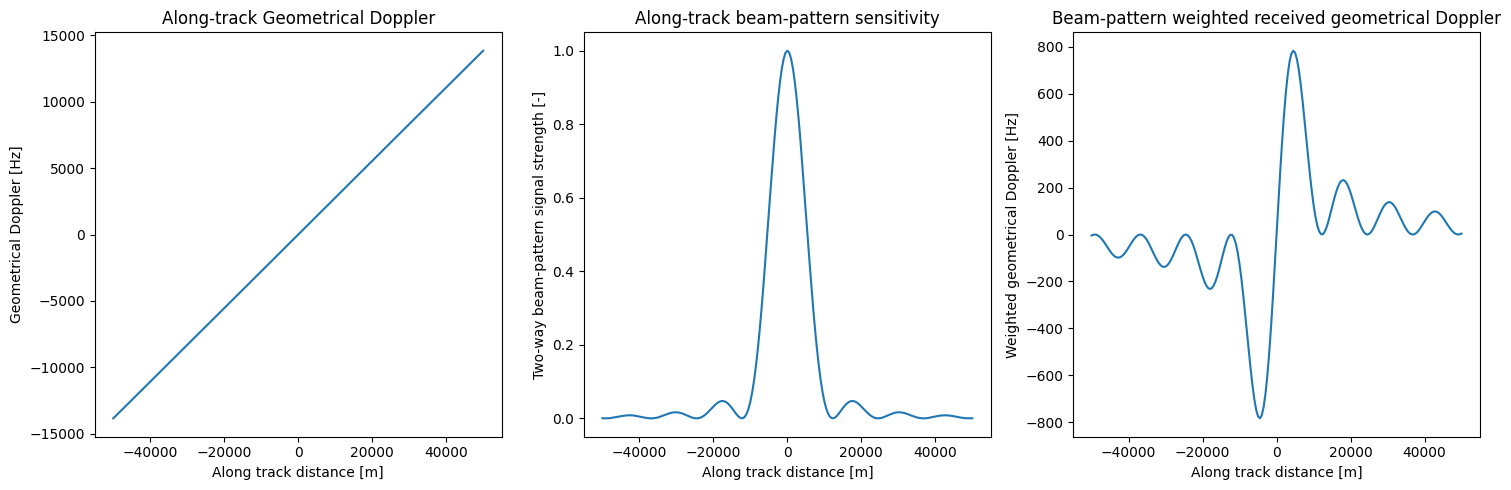

In [4]:

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(15, 5))
ax0 = axes[0]
ax0.plot(ground_azimuth_distance, f_Dop_geom)
ax0.set_title("Along-track Geometrical Doppler")
ax0.set_ylabel("Geometrical Doppler [Hz]")
ax0.set_xlabel("Along track distance [m]")

ax1 = axes[1]
ax1.plot(ground_azimuth_distance, beam_pattern_twoway)
ax1.set_title("Along-track beam-pattern sensitivity")
ax1.set_ylabel("Two-way beam-pattern signal strength [-]")
ax1.set_xlabel("Along track distance [m]")

ax2 = axes[2]
ax2.plot(ground_azimuth_distance, f_Dop_geom*beam_pattern_twoway)
ax2.set_title("Beam-pattern weighted received geometrical Doppler")
ax2.set_ylabel("Weighted geometrical Doppler [Hz]")
ax2.set_xlabel("Along track distance [m]")

fig.tight_layout()

In [5]:
# %% Geophysical Dopplers
import surface_doppler; reload(surface_doppler); from surface_doppler import Doppler_inc

# NOTE we assume points off the Doppler centroid can be modeled with a slightly different incidence angle
# NOTE we still assume a flat Earth and rectilinear path
# NOTE we assume no surface current are present
# TODO find source of discontinuity/jumping values in geophysical Doppler a.f.o. along track

inc_effective = np.arccos(R / R_azimuth) # rad, this account for the slightly increasing incidence angle as a function of slant range away from beam center
phi_w = np.pi/6 # wind direction w.r.t. sensor
phi_w_effective =  phi_w - az_beamwidth # corect for th fact that he relative wind direction changes along beam azimuth
k_r = 2 * np.pi/ Lambda  # radar wave number , rad/m
u_10 = 5 # mean wind speed, m/s
fetch = 10e5 # fetch length for the non-equilibrium part of the spectrum, m

Doppler_v_VV = np.empty(len(inc_effective)) 
sigma_lod_VV = np.empty(len(inc_effective)) 
for i, (inc_e, phi_w_e) in enumerate(tqdm(zip(inc_effective, phi_w_effective))):
    Doppler_v_VV[i], sigma_lod_VV[i]  = Doppler_inc(inc = inc_e, 
                                  phi_w = phi_w_e, 
                                  k_r = k_r,
                                  u_10 = u_10, 
                                  fetch = fetch)

f_Dop_geo = -2 / Lambda * Doppler_v_VV * np.sin(inc_effective) # convert to LOS velocity and geophysical Doppler
backscatter_weight =  (sigma_lod_VV/np.sum(sigma_lod_VV)) / np.max((sigma_lod_VV/np.sum(sigma_lod_VV)))

0it [00:00, ?it/s]

201it [00:17, 11.39it/s]


In [16]:
np.std(f_Dop_geo)

0.04499703134881413

In [15]:
sum((backscatter_weight * beam_pattern_twoway)**2 / len(beam_pattern_twoway))

0.07996246558049622

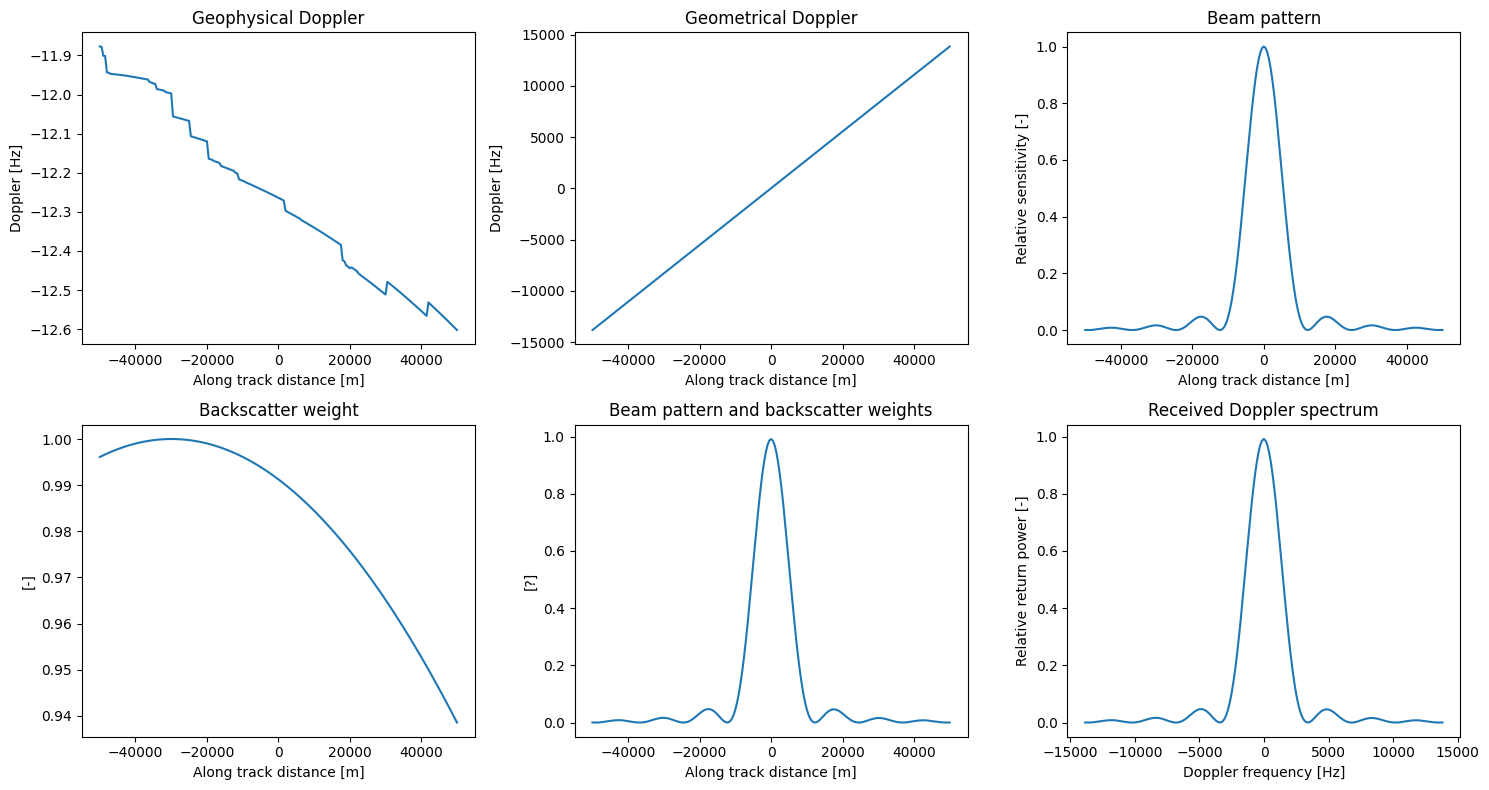

In [7]:
#%%
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(15, 8))
ax0 = axes[0,0]
ax0.plot(ground_azimuth_distance, f_Dop_geo)
ax0.set_title("Geophysical Doppler")
ax0.set_ylabel("Doppler [Hz]")
ax0.set_xlabel("Along track distance [m]")

ax1 = axes[0,1]
ax1.plot(ground_azimuth_distance, f_Dop_geom)
ax1.set_title("Geometrical Doppler")
ax1.set_ylabel("Doppler [Hz]")
ax1.set_xlabel("Along track distance [m]")

ax2 = axes[0,2]
ax2.plot(ground_azimuth_distance, beam_pattern_twoway)
ax2.set_title("Beam pattern")
ax2.set_ylabel("Relative sensitivity [-]")
ax2.set_xlabel("Along track distance [m]")

ax3 = axes[1,0]
ax3.plot(ground_azimuth_distance,backscatter_weight)
ax3.set_title("Backscatter weight")
ax3.set_ylabel("[-]")
ax3.set_xlabel("Along track distance [m]")

ax4 = axes[1,1]
ax4.plot(ground_azimuth_distance, backscatter_weight * beam_pattern_twoway)
ax4.set_title("Beam pattern and backscatter weights")
ax4.set_ylabel("[?]")
ax4.set_xlabel("Along track distance [m]")

ax5 = axes[1,2]
ax5.plot(f_Dop_geo + f_Dop_geom, backscatter_weight * beam_pattern_twoway)
ax5.get_autoscale_on()
ax5.set_title("Received Doppler spectrum")
ax5.set_ylabel("Relative return power [-]")
ax5.set_xlabel("Doppler frequency [Hz]")

fig.tight_layout()

In [103]:
M = 1
T_s = 1.15e-4
relative_power = backscatter_weight * beam_pattern_twoway
frequency = f_Dop_geo + f_Dop_geom
N = len(relative_power)
frequency_res = abs(np.mean(np.diff(frequency)))
spectrum_e = (relative_power / N)**2
spectrum_p = spectrum_e / frequency_res

var_v = Lambda**2 / (M * T_s * sum(spectrum_e**2)) * sum(frequency**2 * spectrum_e**2)
var_v

7595290.979323741

In [41]:
np.trapz(spectrum_p, dx=frequency_res), sum(spectrum_e)

(0.0039782320985100456, 0.003978232118432649)

In [78]:
df = 10

frequency_interp = np.arange(-15e3, 15e3, df)
signal_interp = np.interp(frequency_interp, frequency, relative_power)
signal_interp /= sum(signal_interp)

In [79]:
np.std(signal_interp)

3.721335892080573e-06

In [84]:
sum(np.sqrt(signal_interp / len(signal_interp))**2)

0.00033333333333333115

In [81]:
magnitude = (abs(np.fft.fft(signal_interp)) / len(signal_interp))**2 
sum(magnitude)

1.1112495945194048e-07